In [26]:
!pip install yfinance
!pip install pandas-datareader

In [27]:
import yfinance as yf
import pandas_datareader.data as web
import pandas as pd
from datetime import datetime

# Define timeframe (aligned with your February 2026 proposal date)
start_date = "2020-01-01"
end_date = "2026-02-01"
symbol = "AAPL" # Example stock

# 1. Fetch Stock Data (Yahoo Finance/Alpha Vantage equivalent)
stock_data = yf.download(symbol, start=start_date, end=end_date)

# 2. Fetch Macroeconomic Data (FRED - Interest Rates)
# Note: 'FEstock_dataUNDS' is the code for the Federal Funds Rate
fred_data = web.DataReader(['FEDFUNDS'], 'fred', start_date, end_date)

# 3. Data Integration Process
# Standardizing frequency and merging
stock_data.columns = stock_data.columns.get_level_values(0)

# Create the target for binary classification (Next-day Up=1, Down=0)
stock_data['Target'] = (stock_data['Close'].shift(-1) > stock_data['Close']).astype(int)

[*********************100%***********************]  1 of 1 completed


In [28]:
# Feature Engineering [cite: 136-137]
stock_data['MA 10'] = stock_data['Close'].rolling(window=10).mean()
stock_data['MA 50'] = stock_data['Close'].rolling(window=50).mean()
stock_data['Daily Return'] = stock_data['Close'].pct_change() # Percentage change

# Simple RSI implementation
delta = stock_data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
stock_data['RSI'] = 100 - (100 / (1 + rs))

# Cleaning up nulls caused by rolling windows [cite: 79-81]
stock_data.dropna(inplace=True)

In [43]:
# Required for your report structure
print("--- Dataset Structure (stock_data.info) ---")
print(stock_data.info()) 

print("\n--- Data Preview (stock_data.head) ---")
print(stock_data.head())

print("\n--- Integrity Check (Null Values) ---")
print(stock_data.isnull().sum())

--- Dataset Structure (stock_data.info) ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1479 entries, 2020-03-13 to 2026-01-30
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Close         1479 non-null   float64
 1   High          1479 non-null   float64
 2   Low           1479 non-null   float64
 3   Open          1479 non-null   float64
 4   Volume        1479 non-null   int64  
 5   Target        1479 non-null   int64  
 6   MA 10         1479 non-null   float64
 7   MA 50         1479 non-null   float64
 8   Daily Return  1479 non-null   float64
 9   RSI           1479 non-null   float64
dtypes: float64(8), int64(2)
memory usage: 127.1 KB
None

--- Data Preview (stock_data.head) ---
Price           Close       High        Low       Open     Volume  Target  \
Date                                                                        
2020-03-13  67.164772  67.635946  61.119289  64.004308  37073200

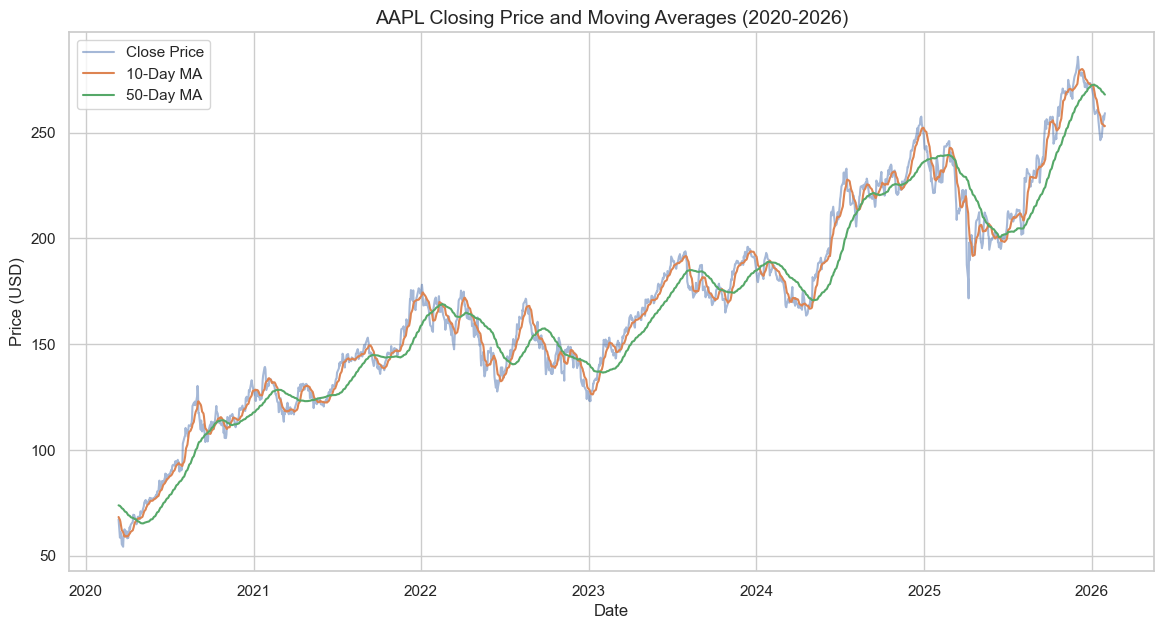

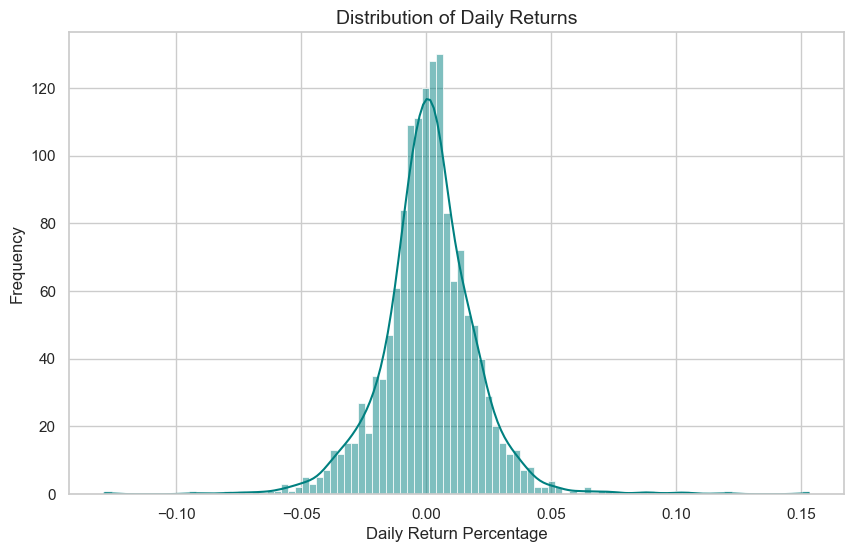

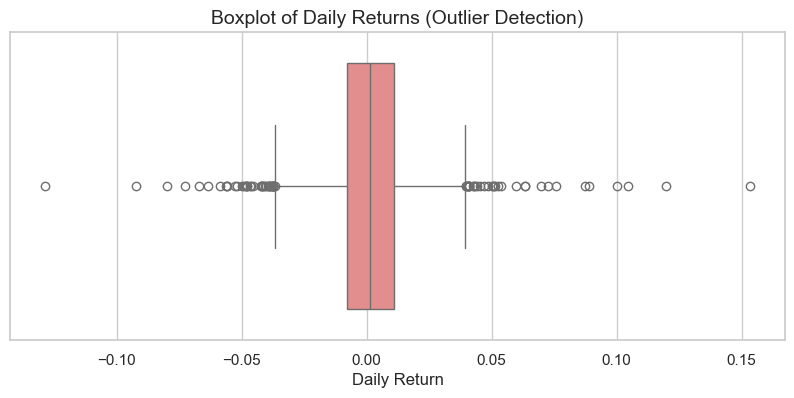

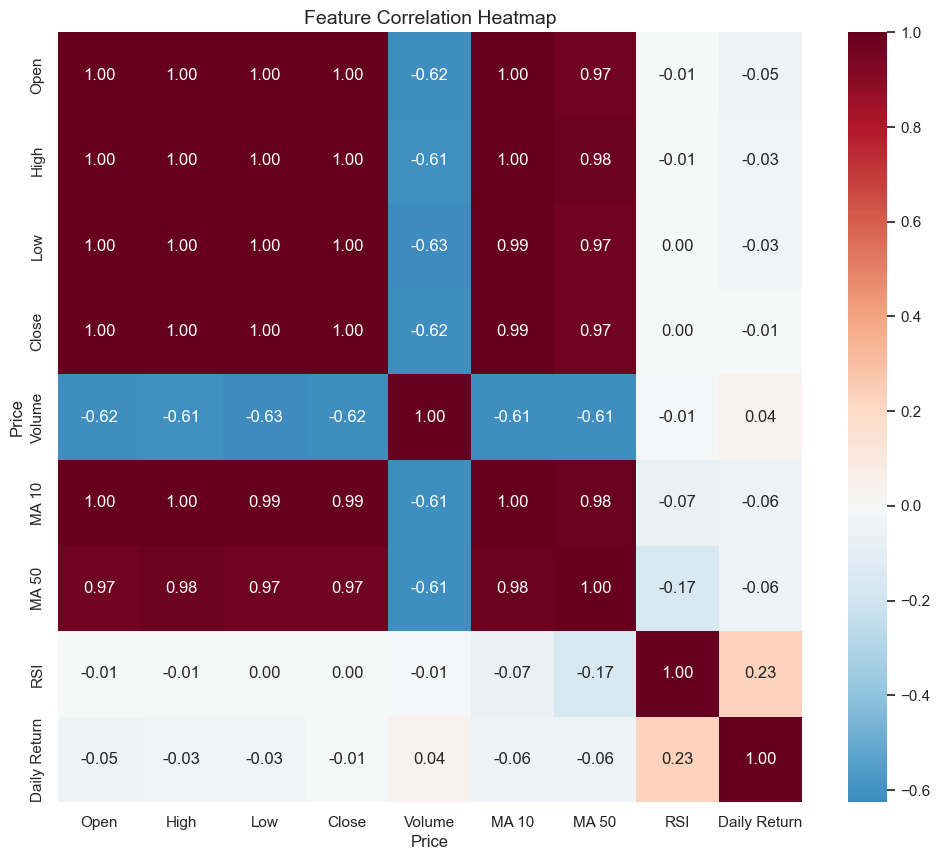

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style
sns.set_theme(style="whitegrid")

# 1. Time Series Visualization (Closing Price & Moving Averages)
plt.figure(figsize=(14, 7))
plt.plot(stock_data.index, stock_data['Close'], label='Close Price', alpha=0.5)
plt.plot(stock_data.index, stock_data['MA 10'], label='10-Day MA', linewidth=1.5)
plt.plot(stock_data.index, stock_data['MA 50'], label='50-Day MA', linewidth=1.5)
plt.title('AAPL Closing Price and Moving Averages (2020-2026)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.savefig('images/time_series_price.png')

# 2. Distribution of Daily Returns
plt.figure(figsize=(10, 6))
sns.histplot(stock_data['Daily Return'], kde=True, color='teal', bins=100)
plt.title('Distribution of Daily Returns', fontsize=14)
plt.xlabel('Daily Return Percentage')
plt.ylabel('Frequency')
plt.savefig('images/returns_distribution.png')

# 3. Boxplot for Outlier Detection
plt.figure(figsize=(10, 4))
sns.boxplot(x=stock_data['Daily Return'], color='lightcoral')
plt.title('Boxplot of Daily Returns (Outlier Detection)', fontsize=14)
plt.xlabel('Daily Return')
plt.savefig('images/outlier_boxplot.png')

# 4. Correlation Matrix
plt.figure(figsize=(12, 10))
# Selecting numerical columns for correlation
corr_stock_data = stock_data[['Open', 'High', 'Low', 'Close', 'Volume', 'MA 10', 'MA 50', 'RSI', 'Daily Return']]
sns.heatmap(corr_stock_data.corr(), annot=True, cmap='RdBu_r', center=0, fmt='.2f')
plt.title('Feature Correlation Heatmap', fontsize=14)
plt.savefig('images/correlation_heatmap.png')

In [31]:
!pip install finnhub-python requests

In [44]:
import finnhub
import requests
import os
from dotenv import load_dotenv

# Load environment variables from .env.local
load_dotenv('.env.local')

# 4. Supplementary Stock Market Validation (Finnhub)
finnhub_api_key = os.getenv('FINNHUB_API_KEY')
finnhub_client = finnhub.Client(api_key=finnhub_api_key)

try:
    # Fetch real-time quote for validation
    # symbol is already defined as 'AAPL' in previous cells
    quote = finnhub_client.quote(symbol)
    print(f"\n--- Finnhub Real-time Quote for {symbol} ---")
    finnhub_df = pd.DataFrame({
        'Current Price (c)': [quote['c']],
        'High (h)': [quote['h']],
        'Low (l)': [quote['l']],
        'Open (o)': [quote['o']],
        'Previous Close (pc)': [quote['pc']],
        'Timestamp (t)': [pd.Timestamp(quote['t'], unit='s')]
    })
    finnhub_df
except Exception as e:
    print(f"Finnhub API Error: {e}")


--- Finnhub Real-time Quote for AAPL ---


In [45]:
# 5. Cross-verification of Technical Indicators (Alpha Vantage)
print("\n--- Alpha Vantage Technical Analysis (RSI) ---")
av_api_key = os.getenv('ALPHA_VANTAGE_API_KEY')
av_url = f'https://www.alphavantage.co/query?function=RSI&symbol={symbol}&interval=daily&time_period=14&series_type=close&apikey={av_api_key}'

try:
    response = requests.get(av_url)
    av_data = response.json()
    
    # Get the latest RSI values from Alpha Vantage
    if 'Technical Analysis: RSI' in av_data:
        rsi_data = av_data['Technical Analysis: RSI']
        av_rsi_df = pd.DataFrame([
            {'Date': date, 'RSI': float(values['RSI'])} 
            for date, values in list(rsi_data.items())[:10]
        ])
        av_rsi_df['Date'] = pd.to_datetime(av_rsi_df['Date'])
        av_rsi_df = av_rsi_df.sort_values('Date', ascending=False).reset_index(drop=True)
        
        print(f"Alpha Vantage RSI Data for {symbol}:")
        av_rsi_df
    else:
        print("Alpha Vantage data structure unexpected or limit reached.")
        av_data
except Exception as e:
    print(f"Alpha Vantage API Error: {e}")


--- Alpha Vantage Technical Analysis (RSI) ---
Alpha Vantage RSI Data for AAPL:


In [37]:
# 6. Final Multi-Source Data Summary
print("Multi-Source Integration Summary:")
print(f"- Yahoo Finance: Historical data up to {stock_data.index[-1].date()}")
print("- FRED: Economic indicators included")
print("- Finnhub: Real-time validation available")
print("- Alpha Vantage: Indicator cross-verification enabled")

Multi-Source Integration Summary:
- Yahoo Finance: Historical data up to 2026-01-30
- FRED: Economic indicators included
- Finnhub: Real-time validation available
- Alpha Vantage: Indicator cross-verification enabled
